
# Coesite, ¹⁷O (I=5/2)

¹⁷O (I=5/2) quadrupolar spectrum simulation.


Coesite is a high-pressure (2-3 GPa) and high-temperature (700°C) polymorph of silicon
dioxide $\text{SiO}_2$. Coesite has five crystallographic $^{17}\text{O}$
sites. In the following, we use the $^{17}\text{O}$ EFG tensor information from
Grandinetti `et al.` [#f1]_



In [1]:
import matplotlib.pyplot as plt

from mrsimulator import Simulator, SpinSystem, Site
from mrsimulator import signal_processor as sp
from mrsimulator.method.lib import BlochDecayCTSpectrum
from mrsimulator.spin_system.tensors import SymmetricTensor
from mrsimulator.method import SpectralDimension

Create the sites.



In [2]:
# default unit of isotropic_chemical_shift is ppm and Cq is Hz.
O17_1 = Site(
    isotope="17O",
    isotropic_chemical_shift=29,
    quadrupolar=SymmetricTensor(Cq=6.05e6, eta=0.000),
)
O17_2 = Site(
    isotope="17O",
    isotropic_chemical_shift=41,
    quadrupolar=SymmetricTensor(Cq=5.43e6, eta=0.166),
)
O17_3 = Site(
    isotope="17O",
    isotropic_chemical_shift=57,
    quadrupolar=SymmetricTensor(Cq=5.45e6, eta=0.168),
)
O17_4 = Site(
    isotope="17O",
    isotropic_chemical_shift=53,
    quadrupolar=SymmetricTensor(Cq=5.52e6, eta=0.169),
)
O17_5 = Site(
    isotope="17O",
    isotropic_chemical_shift=58,
    quadrupolar=SymmetricTensor(Cq=5.16e6, eta=0.292),
)

# all five sites.
sites = [O17_1, O17_2, O17_3, O17_4, O17_5]

Create the spin systems from these sites. For optimum performance, we
create five single-site spin systems instead of a single five-site spin system. The
abundance of each spin system is taken from above reference. Here we are iterating
over both the *sites* and *abundance* list concurrently using a list comprehension
to construct a list of SpinSystems



In [3]:
abundance = [0.83, 1.05, 2.16, 2.05, 1.90]
spin_systems = [SpinSystem(sites=[s], abundance=a) for s, a in zip(sites, abundance)]

Now for the magres-extracted spin system

In [4]:
from ase.io import read
from soprano.selection import AtomSelection
from soprano.properties.nmr import get_spin_system

atoms = read("../example_data/coesite/coesite_nmr.magres")
# Reduce to the unique sites in the system:
atoms = AtomSelection.unique(atoms).subset(atoms)

labels = ["O1", "O2", "O3", "O4", "O5"]

# Create a spin system for each unique site
magres_spin_systems = []
for i, label in enumerate(labels):
    # Get the atoms with the label
    sel = AtomSelection.from_selection_string(atoms, label)
    spin_system = get_spin_system(sel.subset(atoms), references={"O": 286.165}).to_mrsimulator()
    # Update the dictionary to include the abundance
    spin_system["abundance"] = abundance[i]
    magres_spin_systems.append(spin_system)

The mismatched sites are: ['O1' 'O1' 'O2' 'O2' 'O3' 'O3' 'O3' 'O3' 'O4' 'O4' 'O4' 'O4' 'O5' 'O5'
 'O5' 'O5' 'Si1' 'Si1' 'Si1' 'Si1' 'Si2' 'Si2'] at [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22] (/opt/venv/lib/python3.12/site-packages/soprano/properties/labeling/labeling.py, line: 379)
Proceeding with the CIF label reduction rather than the symmetry reduction. (/opt/venv/lib/python3.12/site-packages/soprano/properties/labeling/labeling.py, line: 385)


For now, let's assume that the EFG and MS tensors are aligned with each other in each case and so we can remove all angle parameters from the SpinSystem objects.

In [5]:
# remove all angles from the spin systems
for sys in magres_spin_systems:
    del sys["sites"][0]["shielding_symmetric"]["alpha"]
    del sys["sites"][0]["shielding_symmetric"]["beta"]
    del sys["sites"][0]["shielding_symmetric"]["gamma"]

    # same for quadrupolar tensor
    del sys["sites"][0]["quadrupolar"]["alpha"]
    del sys["sites"][0]["quadrupolar"]["beta"]
    del sys["sites"][0]["quadrupolar"]["gamma"]

Let's examine the generated SpinSystems

In [6]:
magres_spin_systems

[{'sites': [{'isotope': '17O',
    'label': 'O1',
    'isotropic_chemical_shift': 29.650949848018264,
    'shielding_symmetric': {'zeta': -78.63017009152958,
     'eta': 0.028162099399096998},
    'quadrupolar': {'Cq': -6287307.679917204, 'eta': 0.032099292709657945}}],
  'couplings': [],
  'abundance': 0.83},
 {'sites': [{'isotope': '17O',
    'label': 'O2',
    'isotropic_chemical_shift': 41.42581765412775,
    'shielding_symmetric': {'zeta': -59.06542796100695,
     'eta': 0.05830089494103702},
    'quadrupolar': {'Cq': -5578039.226773632, 'eta': 0.23656097133462986}}],
  'couplings': [],
  'abundance': 1.05},
 {'sites': [{'isotope': '17O',
    'label': 'O3',
    'isotropic_chemical_shift': 55.425150869801556,
    'shielding_symmetric': {'zeta': -59.19842631963547,
     'eta': 0.20008979252506623},
    'quadrupolar': {'Cq': -5578696.006906953, 'eta': 0.162954393964735}}],
  'couplings': [],
  'abundance': 2.16},
 {'sites': [{'isotope': '17O',
    'label': 'O4',
    'isotropic_chemic

Create a central transition selective Bloch decay spectrum method.



In [7]:
method = BlochDecayCTSpectrum(
    channels=["17O"],
    rotor_frequency=14000,  # in Hz
    spectral_dimensions=[
        SpectralDimension(
            count=2048,
            spectral_width=50000,  # in Hz
            label=r"$^{17}$O resonances",
        )
    ],
)

The above method is set up to record the $^{17}\text{O}$ resonances at the
magic angle, spinning at 14 kHz and 9.4 T (default, if the value is not provided)
external magnetic flux density. The resonances are recorded over 50 kHz spectral
width using 2048 points.



Create the Simulator object and add method and spin system objects.



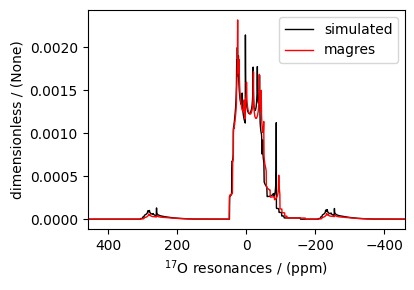

In [8]:
sim = Simulator(spin_systems=spin_systems, methods=[method])
sim.run()

magres_sim = Simulator(spin_systems=magres_spin_systems, methods=[method])
magres_sim.run()

# The plot of the simulation before signal processing.
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(sim.methods[0].simulation.real, color="black", linewidth=1, label="simulated")
ax.plot(magres_sim.methods[0].simulation.real, color="red", linewidth=1, label="magres")
ax.invert_xaxis()
ax.legend()
plt.tight_layout()
plt.show()

Add post-simulation signal processing.



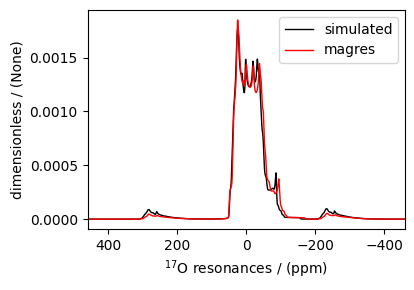

In [9]:
processor = sp.SignalProcessor(
    operations=[
        sp.IFFT(),
        sp.apodization.Exponential(FWHM="30 Hz"),
        sp.apodization.Gaussian(FWHM="145 Hz"),
        sp.FFT(),
    ]
)
processed_dataset = processor.apply_operations(dataset=sim.methods[0].simulation)
magres_processed_dataset = processor.apply_operations(dataset=magres_sim.methods[0].simulation)

# The plot of the simulation after signal processing.
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(processed_dataset.real, color="black", linewidth=1, label="simulated")
ax.plot(magres_processed_dataset.real, color="red", linewidth=1, label="magres")
ax.invert_xaxis()
ax.legend()
plt.tight_layout()
plt.show()

.. [#f1] Grandinetti, P. J., Baltisberger, J. H., Farnan, I., Stebbins, J. F.,
      Werner, U. and Pines, A.
      Solid-State $^{17}\text{O}$ Magic-Angle and Dynamic-Angle Spinning NMR
      Study of the $\text{SiO}_2$ Polymorph Coesite, J. Phys. Chem. 1995,
      **99**, *32*, 12341-12348.
      [DOI: 10.1021/j100032a045](https://doi.org/10.1021/j100032a045)

